# Exploring guest review scores and their relationships with properties of Airbnb hosts/listings/neighbourhoods in London

## Table of Contents
[Business Understanding](#business-understanding)  
* [Determine business objectives](#business-objectives)
* [Assess situation](#assess-situation)
* [Determine data mining goals](#data-mining-goals)
* [Produce project plan](#project-plan)

[Data Understanding](#data-understanding)
* [Collect initial data](#collect-data)
* [Describe data](#describe-data)
* [Explore data](#explore-data)

[Data Preparation](#data-preparation)
* [Select data](#select-data)
* [Clean data](#clean-data)
* [Construct data](#construct-data)
* [Integrate data](#integrate-data)

[Data Understanding](#data-understanding-2)
* [Which neighbourhood is preferable for renting based on guest review scores?](#question-1)
* [Are there any relationships between different types of guest review scores?](#question-2)
* [How host/listings properties are related with guest review scores?](#question-3)

[Evaluation](#evaluation)
* [Evaluate results](#evaluate-results)
* [Review process](#review-process)
* [Determine next steps](#next-steps)

In [1]:
from pathlib import Path

import requests
from tqdm import tqdm

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import altair as alt

In [2]:
sns.set_style('white')

alt.themes.enable('default')
alt.renderers.enable('default')
alt.renderers.set_embed_options(actions=False)
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Business Understanding <a class="anchor" id="business-understanding"></a>

### Determine business objectives <a class="anchor" id="business-objectives"></a>
**Background**  
Airbnb was founded in 2008 and has already become a very popular service for travellers around the world.  

The number of Airbnb listings in London has grown significantly in the past few years, especially after it was legalised in 2015  (https://www.travelgumbo.com/blog/london-legalizes-airbnb-similar-rentals).  

The reputation of the service can be disrupted by fraud (https://www.vice.com/en_us/article/43k7z3/nationwide-fake-host-scam-on-airbnb) or can be increased by different improvements.

One hypothesis that we have is that guest review scores can be reliable factor to evaluate current status of attractiveness of the service in general, and increasing hosts reputation can be the reason for service reputation improvement.

**Business objectives**
- How can Airbnb can improve its reputation for prospective users in London?

**Business success criteria**
- Give useful insights what the overall impression of the Airbnb users depends on and probably how it can be improved

### Assess situation <a class="anchor" id="assess-situation"></a>
**Inventory of resources**
- Data
    - Inside Airbnb project (http://insideairbnb.com/)
- Hardware
    - Google Cloud Platform
- Software
    - Python data science platform (Anaconda)
    
**Requirements, assumptions and constraints**
- Guest review scores can be reliable factors for assessing "attractiveness" of hosts/listings/neighbourhoods
- Better guest reviews will entail service reputation increasing and additional bookings and users

### Determine data mining goals <a class="anchor" id="data-mining-goals"></a>
**Data mining goals**
- Which neighbourhood is preferable for renting based on guest review scores? 
- Are there any relationships between different types of guest review scores?
- How host/listings properties are related with guest review scores?

**Data mining success criteria**
- Define features of hosts/listings/neighbourhoods that have strong relationships with guest review score types

### Produce project plan <a class="anchor" id="project-plan"></a>
**Project plan**
- Gather
    - Data source: Airbnb data for London from Inside Airbnb project
- Assess
    - Describe data
    - Explore data for useful features
- Clean
    - Select required subset of data
    - Preprocess categorical data
    - Preprocess missing data
    - Generate additional features based on selected ones
- Analyze
    - Analyze data for answering relevant questions
- Visualize
    - Visualize findings
- Results
    - Formulate the answers for the business/data mining questions

**Initial assessment of tools and techniques**
- Programming language  
  - Python
- Packages
  - Data loading
      - requests, pandas, geopandas
  - Data analysis
      - numpy, pandas, geopandas
  - Visualization
      - matplotlib, seaborn, altair

## Data Understanding <a class="anchor" id="data-understanding"></a>

### Collect initial data <a class="anchor" id="collect-data"></a>

In [3]:
DOWNLOAD_DATE = '2019-11-05'
BASE_DATA_URL = f'http://data.insideairbnb.com/united-kingdom/england/london/{DOWNLOAD_DATE}/data'
BASE_VIZ_URL = f'http://data.insideairbnb.com/united-kingdom/england/london/{DOWNLOAD_DATE}/visualisations'
DATA_PATH = Path('./data')

CHUNK_SIZE = 4096

def download_files(base_url, file_names, data_path):
    '''Download files 
    
    Download multiple files from specified source by url name 
    and save to local disk to specific path
    
    :param url: base part of url of the data source (without file name) to download
    :type url: str
    :param file_names: the list of file names to download
    :type file_names: list
    :param data_path: directory path name for saving downloaded files
    :type data_path: Path
    :return: no value
    :rtype: none
    '''
    data_path.mkdir(parents=True, exist_ok=True)
    
    for file_name in tqdm(file_names):
        file_path = data_path/file_name
    
        if file_path.exists():
            continue

        resp = requests.get(f'{base_url}/{file_name}', stream=True)

        with open(file_path, 'wb') as f:
            for chunk in resp.iter_content(chunk_size=CHUNK_SIZE):
                f.write(chunk)

In [4]:
DATA_FILE_NAMES = ['listings.csv.gz', 'calendar.csv.gz', 'reviews.csv.gz']
VIZ_FILE_NAMES = ['listings.csv', 'reviews.csv', 'neighbourhoods.csv', 'neighbourhoods.geojson']

download_files(BASE_DATA_URL, DATA_FILE_NAMES, DATA_PATH)
download_files(BASE_VIZ_URL, VIZ_FILE_NAMES, DATA_PATH)

100%|██████████| 4/4 [00:00<00:00, 5991.86it/s]


In [5]:
listings_df = pd.read_csv(DATA_PATH/'listings.csv',
                          parse_dates=['last_review'])
listings_detail_df = pd.read_csv(DATA_PATH/'listings.csv.gz', low_memory=False,
                                 parse_dates=['host_since', 
                                              'last_scraped', 'calendar_last_scraped',
                                              'first_review', 'last_review'])

reviews_df = pd.read_csv(DATA_PATH/'reviews.csv', parse_dates=['date'])
reviews_detail_df = pd.read_csv(DATA_PATH/'reviews.csv.gz', parse_dates=['date'])

calendar_df = pd.read_csv(DATA_PATH/'calendar.csv.gz', parse_dates=['date'])

neighbourhoods_df = pd.read_csv(DATA_PATH/'neighbourhoods.csv')
gdf = gpd.read_file(DATA_PATH/'neighbourhoods.geojson')

**Initial data collection report**
- Data source
    - http://insideairbnb.com/get-the-data.html
    - Section "London, England, United Kingdom"  


- Data files
    - Detailed Listings data for London  
    http://data.insideairbnb.com/united-kingdom/england/london/2019-11-05/data/listings.csv.gz
    
    - Detailed Calendar Data for listings in London  
    http://data.insideairbnb.com/united-kingdom/england/london/2019-11-05/data/calendar.csv.gz

    - Detailed Review Data for listings in London  
    http://data.insideairbnb.com/united-kingdom/england/london/2019-11-05/data/reviews.csv.gz

    - Summary information and metrics for listings in London (good for visualisations)  
    http://data.insideairbnb.com/united-kingdom/england/london/2019-11-05/visualisations/listings.csv

    - Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing)  
    http://data.insideairbnb.com/united-kingdom/england/london/2019-11-05/visualisations/reviews.csv

    - Neighbourhood list for geo filter. Sourced from city or open source GIS files  
    http://data.insideairbnb.com/united-kingdom/england/london/2019-11-05/visualisations/neighbourhoods.csv

    - GeoJSON file of neighbourhoods of the city  
    http://data.insideairbnb.com/united-kingdom/england/london/2019-11-05/visualisations/neighbourhoods.geojson
    
    
- Data access 
    - Data is refreshed periodically on the site, but the links for previous versions of data are still available

### Describe data <a class="anchor" id="describe-data"></a>

**Summary information and metrics for listings in London**

In [6]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85068 entries, 0 to 85067
Data columns (total 16 columns):
id                                85068 non-null int64
name                              85043 non-null object
host_id                           85068 non-null int64
host_name                         85056 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     85068 non-null object
latitude                          85068 non-null float64
longitude                         85068 non-null float64
room_type                         85068 non-null object
price                             85068 non-null int64
minimum_nights                    85068 non-null int64
number_of_reviews                 85068 non-null int64
last_review                       65062 non-null datetime64[ns]
reviews_per_month                 65062 non-null float64
calculated_host_listings_count    85068 non-null int64
availability_365                  85068 non-null 

**Detailed Listings data for London**

In [7]:
listings_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85068 entries, 0 to 85067
Columns: 106 entries, id to reviews_per_month
dtypes: datetime64[ns](5), float64(23), int64(21), object(57)
memory usage: 68.8+ MB


In [8]:
print(listings_detail_df.columns.tolist())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

**Detailed Calendar Data for listings in London**

In [9]:
calendar_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31050094 entries, 0 to 31050093
Data columns (total 7 columns):
listing_id        31050094 non-null int64
date              31050094 non-null datetime64[ns]
available         31050094 non-null object
price             31049176 non-null object
adjusted_price    31049176 non-null object
minimum_nights    31050084 non-null float64
maximum_nights    31050084 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.6+ GB


**Summary Review data and Listing ID**

In [10]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486236 entries, 0 to 1486235
Data columns (total 2 columns):
listing_id    1486236 non-null int64
date          1486236 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.7 MB


**Detailed Review Data for listings in London**

In [11]:
reviews_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486236 entries, 0 to 1486235
Data columns (total 6 columns):
listing_id       1486236 non-null int64
id               1486236 non-null int64
date             1486236 non-null datetime64[ns]
reviewer_id      1486236 non-null int64
reviewer_name    1486236 non-null object
comments         1485614 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 68.0+ MB


**Neighbourhood list for geo filter**

In [12]:
neighbourhoods_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 2 columns):
neighbourhood_group    0 non-null float64
neighbourhood          33 non-null object
dtypes: float64(1), object(1)
memory usage: 656.0+ bytes


**GeoJSON file of neighbourhoods of the city**

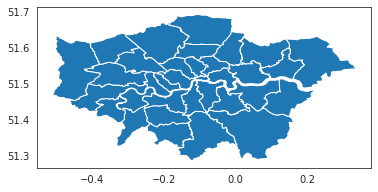

In [13]:
gdf.plot();

**Data description report**  
- Data summary statistics described above are self-explanatory
- Additional data considerations are available on the Inside Airbnb project page:  
http://insideairbnb.com/about.html

### Explore data <a class="anchor" id="explore-data"></a>

**Summary information and metrics for listings in London**

Sample of data

In [14]:
listings_df.head(1)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,11551,Arty and Bright London Apartment in Zone 2,43039,Adriano,NaN,Lambeth,51.46225,-0.11732,Entire home/apt,88,3,185,2019-09-15,1.58,2,336


Features with non-zero number of missing values

In [15]:
print(listings_df.shape)
listings_df.loc[:, listings_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(85068, 16)


neighbourhood_group    85068
reviews_per_month      20006
last_review            20006
name                      25
host_name                 12
dtype: int64

Features with zero variance

In [16]:
listings_df.loc[:, listings_df.nunique() <= 1].nunique().sort_values()

neighbourhood_group    0
dtype: int64

Summary information for datetime features

In [17]:
listings_df.describe(include='datetime')

,last_review
count,65062
unique,1818
top,2019-11-03 00:00:00
freq,1688
first,2011-07-02 00:00:00
last,2019-11-06 00:00:00


Summary information for string features

In [18]:
listings_df.describe(include=['object'])

,name,host_name,neighbourhood,room_type
count,85043,85056,85068,85068
unique,82447,14573,33,4
top,Double room,Veeve,Westminster,Entire home/apt
freq,37,1235,9588,47445


Number of listings by neighbourhood

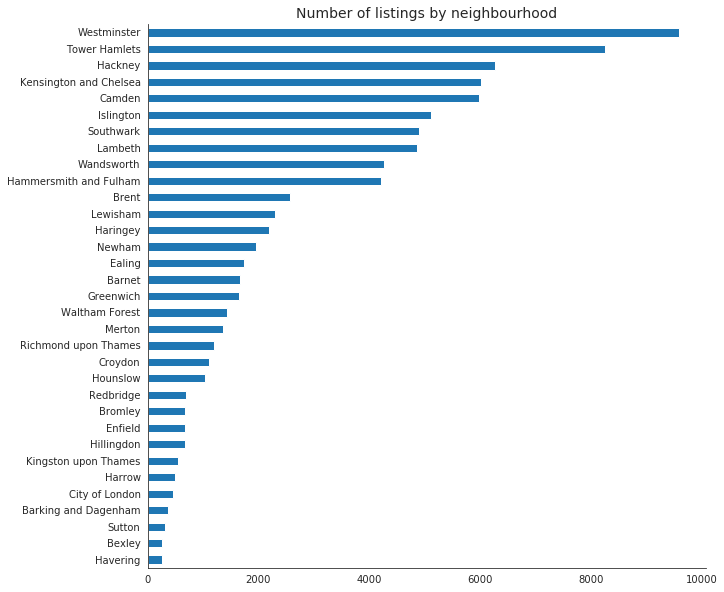

In [19]:
listings_df['neighbourhood'].value_counts().sort_values().plot.barh(figsize=(10, 10));
sns.despine()
plt.title('Number of listings by neighbourhood', fontsize=14);

Number of listings by room type

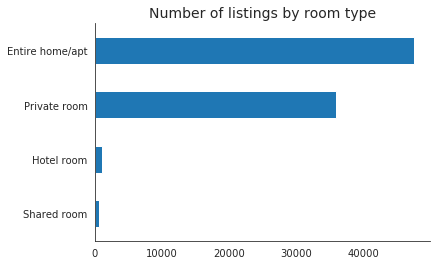

In [20]:
listings_df['room_type'].value_counts(dropna=False).sort_values().plot.barh()
sns.despine()
plt.title('Number of listings by room type', fontsize=14);

Numeric features distribution

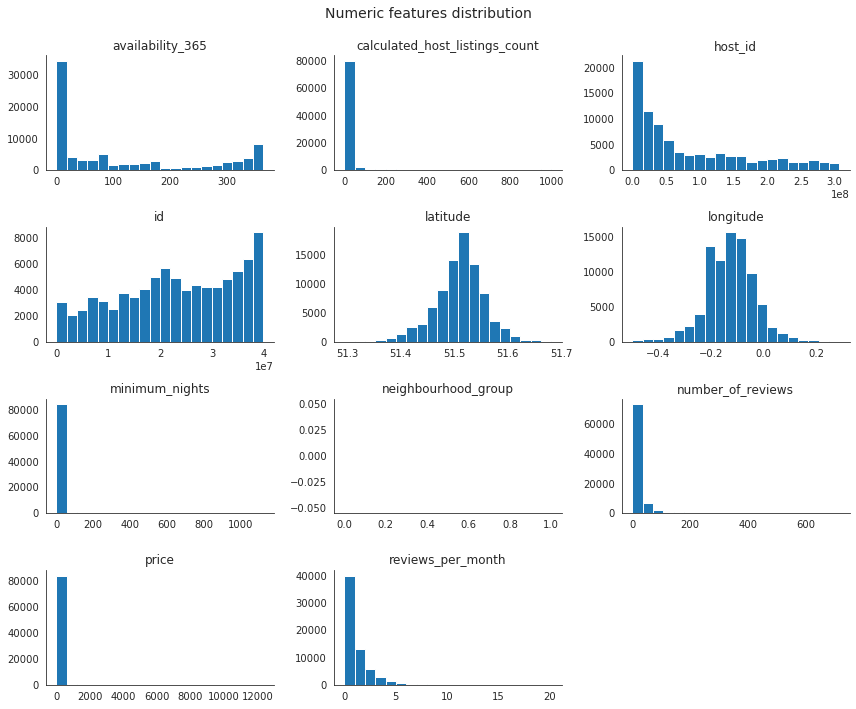

In [21]:
listings_df.hist(figsize=(12, 10), bins=20, grid=False)
sns.despine()
plt.suptitle('Numeric features distribution', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])

**Detailed Listings data for London**

Sample of data

In [22]:
listings_detail_df.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20191105115249,2019-11-06,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,"Amenities Bedding: 1 Double bed, 1 living room...",Unlike most rental apartments out there my fla...,family,Not even 10 minutes by metro from Victoria Sta...,...,t,f,strict_14_with_grace_period,f,t,2,2,0,0,1.58


Features with non-zero number of missing values

In [23]:
print(listings_detail_df.shape)
listings_detail_df.loc[:, listings_detail_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(85068, 106)


medium_url                      85068
xl_picture_url                  85068
neighbourhood_group_cleansed    85068
host_acceptance_rate            85068
thumbnail_url                   85068
jurisdiction_names              85066
license                         84889
square_feet                     84671
monthly_price                   80103
weekly_price                    78112
notes                           52269
access                          39320
house_rules                     35807
host_about                      35751
interaction                     35286
transit                         30748
neighborhood_overview           30374
security_deposit                29125
host_response_rate              25900
host_response_time              25900
space                           25850
review_scores_checkin           21723
review_scores_value             21722
review_scores_location          21721
review_scores_accuracy          21675
review_scores_communication     21667
review_score

Features with zero variance

In [24]:
listings_detail_df.loc[:, listings_detail_df.nunique() <= 1].nunique().sort_values()

thumbnail_url                   0
medium_url                      0
xl_picture_url                  0
host_acceptance_rate            0
neighbourhood_group_cleansed    0
scrape_id                       1
has_availability                1
jurisdiction_names              1
is_business_travel_ready        1
dtype: int64

Missing values count distribution for review scores by row

In [25]:
listings_detail_df.filter(regex='review_scores').notnull().sum(axis=1).value_counts(normalize=True)

7    0.744310
0    0.254103
4    0.000470
3    0.000400
6    0.000270
1    0.000259
2    0.000141
5    0.000047
dtype: float64

Summary information for datetime features

In [26]:
listings_detail_df.describe(include='datetime')

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
count,85068,85056,85068,65062,65062
unique,2,3459,2,2802,1818
top,2019-11-06 00:00:00,2015-05-21 00:00:00,2019-11-06 00:00:00,2019-01-01 00:00:00,2019-11-03 00:00:00
freq,59108,1034,59108,205,1688
first,2019-11-05 00:00:00,2008-09-03 00:00:00,2019-11-05 00:00:00,2009-12-21 00:00:00,2011-07-02 00:00:00
last,2019-11-06 00:00:00,2019-11-04 00:00:00,2019-11-06 00:00:00,2019-11-06 00:00:00,2019-11-06 00:00:00


Summary information for string features

In [27]:
listings_detail_df.describe(include='object').T

,count,unique,top,freq
listing_url,85068,85068,https://www.airbnb.com/rooms/21391335,1
name,85043,82446,Double room,37
summary,80736,74249,"Featured in The New York Times, The Wall Stree...",214
space,59218,53964,Duchy House is a 19th century building and has...,30
description,82683,78831,Lovely studios situated in an excellent centra...,26
experiences_offered,85068,5,none,83388
neighborhood_overview,54694,44382,Conveniently located in Maida Vale one of Lond...,66
notes,32799,25384,"No smoking, pets or parties!",151
transit,54320,45959,Transport links are excellent with convenient ...,93
access,45748,33418,Guests will have access to the entire property...,1583


Country codes distribution

In [28]:
print(listings_detail_df['country_code'].value_counts())
listings_detail_df.query('country_code != "GB"')

GB    85065
FR        2
ES        1
Name: country_code, dtype: int64


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
41783,23325697,https://www.airbnb.com/rooms/23325697,20191105115249,2019-11-06,Can torres,M7 minutes to Ibiza Town,NaN,M7 minutes to Ibiza Town,none,NaN,...,t,f,flexible,f,f,1,1,0,0,NaN
57006,30320965,https://www.airbnb.com/rooms/30320965,20191105115249,2019-11-05,"Chambre idéal pour couple, 10min à pied de Camden",Chambre lumineuse très bien situé à 7min à pie...,L’appartement est calme et très bien situé pou...,Chambre lumineuse très bien situé à 7min à pie...,none,Vous trouverez une station de métro (Kentish T...,...,f,f,flexible,f,f,1,0,1,0,0.1
61178,32394504,https://www.airbnb.com/rooms/32394504,20191105115249,2019-11-06,"Cosy one bedroom , near station Edgware",NaN,NaN,NaN,none,NaN,...,f,f,flexible,f,f,2,1,1,0,NaN


Numeric features distribution

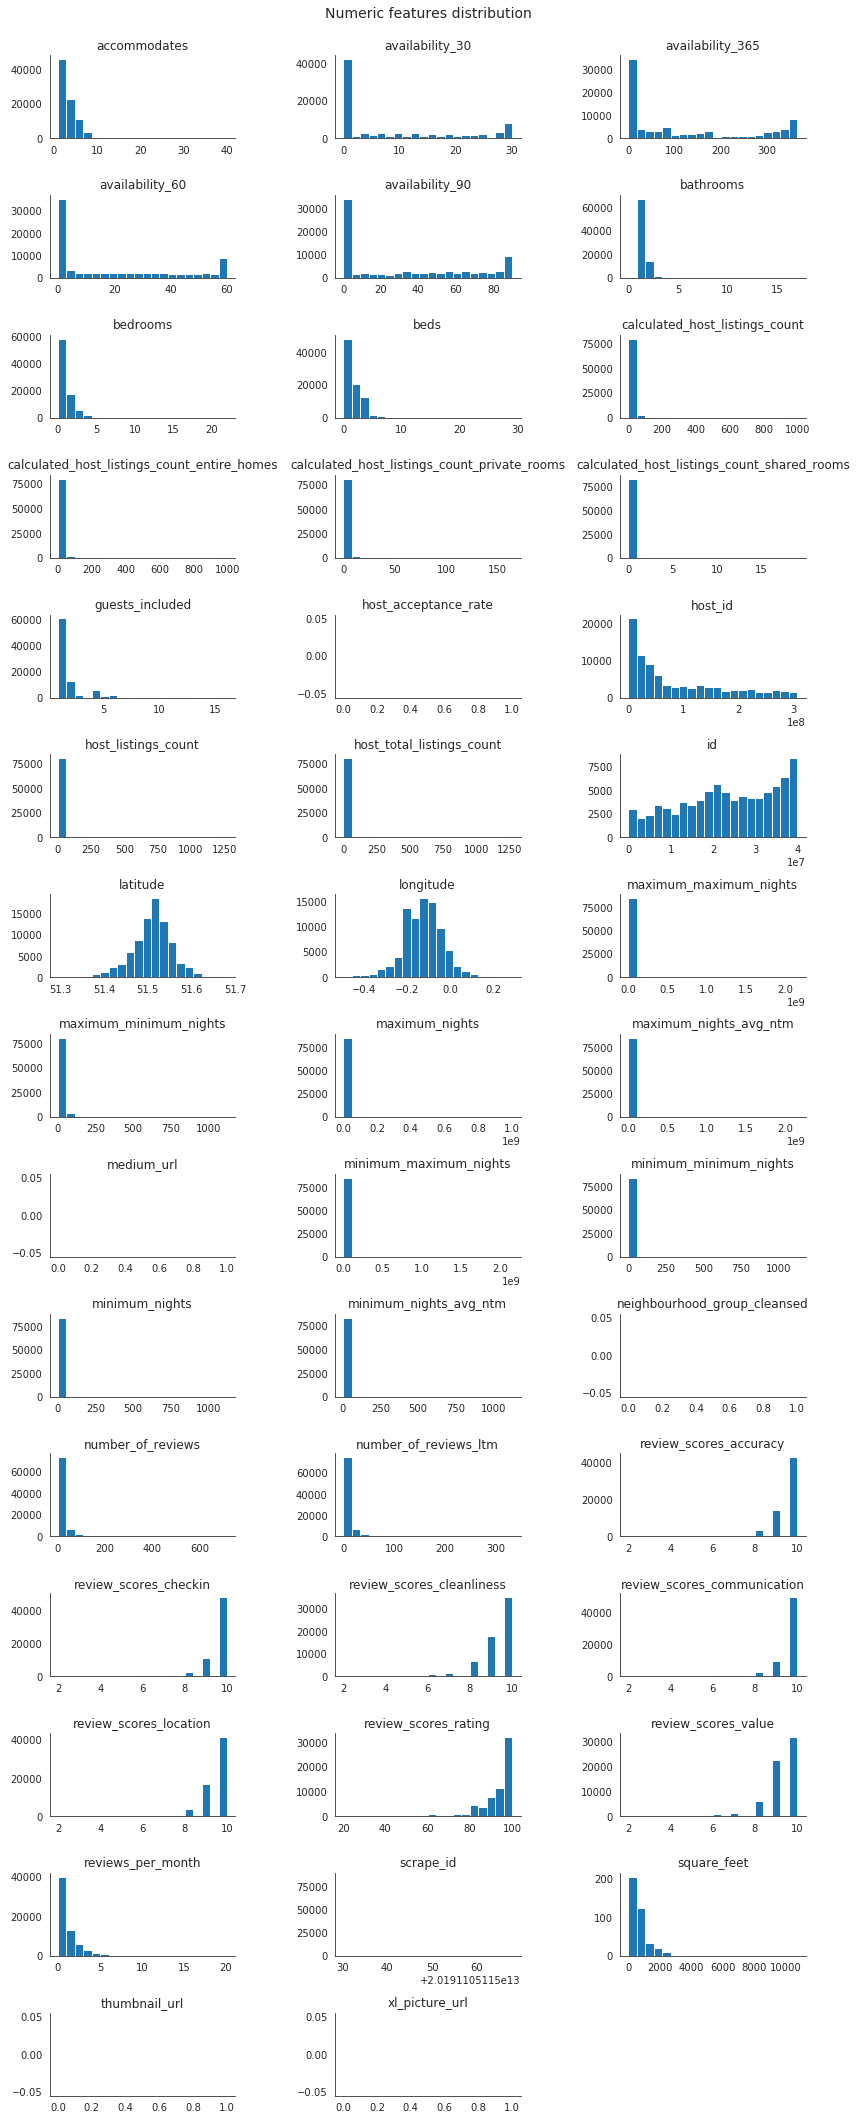

In [29]:
listings_detail_df.hist(figsize=(12, 30), bins=20, grid=False, layout=(15, 3))
sns.despine()
plt.suptitle('Numeric features distribution', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])

**Detailed Calendar Data for listings in London**

Sample of data

In [30]:
calendar_df.head(1)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,11551,2019-11-06,f,$105.00,$105.00,3.0,180.0


Features with non-zero number of missing values

In [31]:
print(calendar_df.shape)
calendar_df.loc[:, calendar_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(31050094, 7)


adjusted_price    918
price             918
maximum_nights     10
minimum_nights     10
dtype: int64

Summary information for datetime features

In [32]:
calendar_df.describe(include='datetime')

,date
count,31050094
unique,366
top,2020-07-05 00:00:00
freq,85068
first,2019-11-05 00:00:00
last,2020-11-04 00:00:00


Summary information for string features

In [33]:
calendar_df.describe(include='object')

,available,price,adjusted_price
count,31050094,31049176,31049176
unique,2,2684,2696
top,f,$50.00,$50.00
freq,20898260,949237,949577


**Summary Review data and Listing ID**

Sample of data

In [34]:
reviews_df.head(1)

,listing_id,date
0,11551,2010-03-21


Features with non-zero number of misssing values

In [35]:
print(reviews_df.shape)
reviews_df.loc[:, reviews_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(1486236, 2)


Series([], dtype: float64)

Summary information for datetime features

In [36]:
reviews_df.describe(include='datetime')

,date
count,1486236
unique,3302
top,2019-07-07 00:00:00
freq,3731
first,2009-12-21 00:00:00
last,2019-11-06 00:00:00


Numeric features distribution

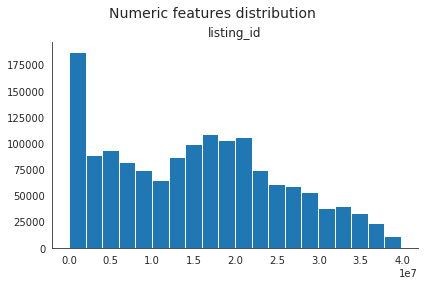

In [37]:
reviews_df.hist(bins=20, grid=False)
sns.despine()
plt.suptitle('Numeric features distribution', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])

**Detailed Review Data for listings in London**

Sample of data

In [38]:
reviews_detail_df.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and..."


Features with non-zero number of missing values

In [39]:
print(reviews_detail_df.shape)
reviews_detail_df.loc[:, reviews_detail_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(1486236, 6)


comments    622
dtype: int64

Summary information for datetime features

In [40]:
reviews_detail_df.describe(include='datetime')

,date
count,1486236
unique,3302
top,2019-07-07 00:00:00
freq,3731
first,2009-12-21 00:00:00
last,2019-11-06 00:00:00


Summary information for string features

In [41]:
reviews_detail_df.describe(include='object')

,reviewer_name,comments
count,1486236,1485614
unique,141702,1426862
top,David,The host canceled this reservation 2 days befo...
freq,12654,1646


Numeric features distribution

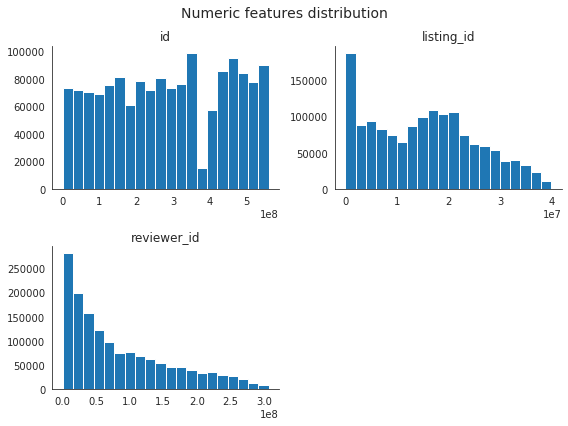

In [42]:
reviews_detail_df.hist(figsize=(8, 6), bins=20, grid=False)
sns.despine()
plt.suptitle('Numeric features distribution', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])

**Neighbourhood list for geo filter**

Sample of data

In [43]:
neighbourhoods_df.head(1)

,neighbourhood_group,neighbourhood
0,NaN,Barking and Dagenham


Features with non-zero number of missing values

In [44]:
print(neighbourhoods_df.shape)
neighbourhoods_df.loc[:, neighbourhoods_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(33, 2)


neighbourhood_group    33
dtype: int64

Summary information for string features

In [45]:
neighbourhoods_df.describe(include='object')

,neighbourhood
count,33
unique,33
top,Hammersmith and Fulham
freq,1


**GeoJSON file of neighbourhoods of the city**

Sample of data

In [46]:
gdf.head(1)

,neighbourhood,neighbourhood_group,geometry
0,Kingston upon Thames,None,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."


Features with non-zero number of missing values

In [47]:
print(gdf.shape)
gdf.loc[:, gdf.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(33, 3)


neighbourhood_group    33
dtype: int64

Summary information for string features

In [48]:
gdf.describe(include='object')

,neighbourhood,neighbourhood_group
count,33,0
unique,33,0
top,Hammersmith and Fulham,NaN
freq,1,NaN


**Data exploration report**  
Listings data
- Contains data for host which are registered from 2008-09-03 00:00:00 to 2019-11-04 00:00:00
- Features
    - There are a lot of higly skewed numeric features
    - There are many text features with different descriptions
    - Data has 3 listings with non-GB country code (2 - France, 1 - Spain) and strange location (according to their information pages)
- Missing values    
    - There are features with all null values
    - There are features which are related to the same entity with the same number of missing values 
        - There are 12 hosts with most empty host-related columns
        - There are more than 25% of records with any empty review scores
    - A lot of features have missing values        
    
Calendar data 
- Contains data for availability and price from 2019-11-05 00:00:00 to 2020-11-04 00:00:00
- Features
    - This data is not reliable corresponding to Inside Airbnb project data description (http://insideairbnb.com/about.html)
- Missing values
    - There are few missing values for price and renting period information   
    
Reviews data
- Contains data for reviews created from 2009-12-21 00:00:00 to 2019-11-06 00:00:00
- Features
    - Data is related to only reviewers and their reviews on specific listings
- Missing values
    - There are few missing values only for reviews
    
Geo data 
- Contains geo information for all 33 neighbourhoods of London with their names

The following information can be useful for the further analysis:  
- Multiple types of guest review scores
- Neighbourhood properties
- Host properties
- Listing properties

For further analysis and answering questions we will use only the following datasets:
- Detailed listings data for London
- GeoJSON file of neighbourhoods of the city

## Data preparation <a class="anchor" id="data-preparation"></a>

### Select data <a class="anchor" id="select-data"></a>

Select necessary columns and rows for further analysis

In [49]:
review_cols = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value']
host_cols = ['host_since', 'host_response_time',
             'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']

listing_detail_cols = ['id', 'instant_bookable', 'neighbourhood_cleansed', 'room_type'] + review_cols + host_cols 


res_listings_detail_df = listings_detail_df.query('country_code == "GB"')
res_listings_detail_df = res_listings_detail_df[res_listings_detail_df['host_name'].notnull()]
res_listings_detail_df = res_listings_detail_df[res_listings_detail_df.filter(regex='review_scores').notnull().all(axis=1)]
res_listings_detail_df = res_listings_detail_df[listing_detail_cols].rename({'neighbourhood_cleansed': 'neighbourhood'}, axis=1)
res_listings_detail_df.head()

,id,instant_bookable,neighbourhood,room_type,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_since,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified
0,11551,t,Lambeth,Entire home/apt,9.0,9.0,10.0,10.0,9.0,9.0,2009-10-03,within an hour,t,t,t
2,13913,f,Islington,Private room,10.0,10.0,10.0,10.0,9.0,9.0,2009-11-16,within a few hours,f,t,f
3,38407,t,Tower Hamlets,Entire home/apt,9.0,10.0,10.0,10.0,9.0,9.0,2010-07-12,a few days or more,f,t,f
4,90700,t,Kensington and Chelsea,Entire home/apt,9.0,9.0,10.0,10.0,10.0,9.0,2011-04-07,within a day,f,t,f
5,15400,t,Kensington and Chelsea,Entire home/apt,10.0,10.0,10.0,10.0,10.0,9.0,2009-12-05,NaN,f,t,t


Summary information for selected subset of data

In [50]:
res_listings_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63313 entries, 0 to 85052
Data columns (total 15 columns):
id                             63313 non-null int64
instant_bookable               63313 non-null object
neighbourhood                  63313 non-null object
room_type                      63313 non-null object
review_scores_accuracy         63313 non-null float64
review_scores_cleanliness      63313 non-null float64
review_scores_checkin          63313 non-null float64
review_scores_communication    63313 non-null float64
review_scores_location         63313 non-null float64
review_scores_value            63313 non-null float64
host_since                     63313 non-null datetime64[ns]
host_response_time             47964 non-null object
host_is_superhost              63313 non-null object
host_has_profile_pic           63313 non-null object
host_identity_verified         63313 non-null object
dtypes: datetime64[ns](1), float64(6), int64(1), object(7)
memory usage: 7.7+ MB


**GeoJSON file of neighbourhoods of the city**

Select non-null geo data for further analysis

In [51]:
geo_cols = ['neighbourhood', 'geometry']
res_gdf = gdf.loc[:, geo_cols]
res_gdf.head()

,neighbourhood,geometry
0,Kingston upon Thames,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,Croydon,"MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51..."
2,Bromley,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2..."
3,Hounslow,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51..."
4,Ealing,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."


**Rationale for inclusion/exclusion**  
Guest review scores
- Reason to include
    - Main features for analysis

- Features
    - review_scores_accuracy 
        - How accurately did the listing page represent the space?
    - review_scores_cleanliness
        - Did guests feel that the space was clean and tidy?
    - review_scores_checkin
        - How smoothly did check-in go?
    - review_scores_communication
        - How well did you communicate before and during the stay?
    - review_scores_location
        - How did guests feel about the neighborhood?
    - review_scores_value
        - Did the guest feel that the listing provided good value for the price?
        
Neighbourhood properties
- Reasons to include 
    - Necessary information for calculating and comparing values by different neighbourhoods
- Features
    - neighbourhood
        - Neighbourhood name
        
Host properties
- Reasons to include
    - We can assume that host properties (related with status, security, responsiveness etc) have relationship with guest review scores
- Features
    - host_since
        - Registration date of the host
    - host_response_time
        - Average time of response by host
    - host_is_superhost
        - Whether host is superhost
    - host_has_profile_pic
        - Whether host has picture in profile
    - host_identity_verified
        - Is host's identity verified
        
Listing properties
- Reasons to include 
    - Different guests can be comfortable with different type of housing to live or process of booking
- Features
    - listing_id 
        - Listing unique identificator
    - room_type
        - Type of housing
    - instant_bookable
        - Whether additional approval by host is required for booking 

- 3 listings with non-GB country codes are deleted
- 12 listings with most empty host-related columns are deleted
- All listings with any empty review score are deleted

Geo data
- Reasons to include 
    - Necessary information for plotting and merging geo data to listings data later
- Features
    - neigbourhood
        - Neighbourhood name
    - geometry
        - Geo data for neighbourhoods (polygons)

### Clean data <a class="anchor" id="clean-data"></a>

**Summary information and metrics for listings in London**

No cleaning

**Detailed Listings data for London**

Convert columns to required types, clean data, and calculate non-aggregated features

In [52]:
binary_cols = ['instant_bookable', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']
binary_map = {'f': False, 't': True}
res_listings_detail_df[binary_cols] = res_listings_detail_df[binary_cols].apply(lambda x: x.map(binary_map)).astype(bool)

cat_type = pd.api.types.CategoricalDtype(['not specified', 'within an hour', 'within a few hours', 'within a day', 'a few days or more'])
res_listings_detail_df['host_response_time'] = res_listings_detail_df['host_response_time'].fillna('not specified').astype(cat_type)

Summary information after cleaning

In [53]:
res_listings_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63313 entries, 0 to 85052
Data columns (total 15 columns):
id                             63313 non-null int64
instant_bookable               63313 non-null bool
neighbourhood                  63313 non-null object
room_type                      63313 non-null object
review_scores_accuracy         63313 non-null float64
review_scores_cleanliness      63313 non-null float64
review_scores_checkin          63313 non-null float64
review_scores_communication    63313 non-null float64
review_scores_location         63313 non-null float64
review_scores_value            63313 non-null float64
host_since                     63313 non-null datetime64[ns]
host_response_time             63313 non-null category
host_is_superhost              63313 non-null bool
host_has_profile_pic           63313 non-null bool
host_identity_verified         63313 non-null bool
dtypes: bool(4), category(1), datetime64[ns](1), float64(6), int64(1), object(2)
memory u

**Data cleaning report**  

Summary information and metrics for listings in London
- No cleaning

Detailed Listings data for London
- Binary columns 
    - instant_bookable, host_is_superhost, host_has_profile_pic, host_identity_verified
    - Convert binary columns to boolean type
- host_response_rate
    - Clean
        - Remove "%" symbol
        - Convert to float type
- host_response_time
     - Convert to ordered categorical type
     - All empty values impute with unique value ("not specified")
        - Assumption that lack of information is useful for analyzing guest review relationships 

### Construct data <a class="anchor" id="construct-data"></a>

Calculate non-aggregated features based on geodata

In [54]:
res_gdf['area_sq_km'] = (res_gdf['geometry'].to_crs({'init': 'epsg:3395'})
                                    .map(lambda p: p.area / 10**6))

res_listings_detail_df['age'] = (pd.Timestamp('now') - pd.to_datetime(res_listings_detail_df['host_since'])).dt.days.div(365.25).round(2)

**Derived attributes**

- area_sq_km
    - Area of the neighbourhood in squared kilometers
- age
    - How long host has been registered on Airbnb site

### Integrate Data <a class="anchor" id="integrate-data"></a>

Merge data and calculate aggregated features

In [55]:
geo_listings_df = res_gdf.merge(res_listings_detail_df, how='inner', on='neighbourhood')

geo_listings_df['listings_count'] = geo_listings_df.groupby('neighbourhood')['id'].transform('count')
geo_listings_df['listings_density'] = geo_listings_df.groupby('neighbourhood')['area_sq_km'].transform(lambda x: len(x) / x)

geo_listings_df['mean_review_scores_accuracy'] = geo_listings_df.groupby('neighbourhood')['review_scores_accuracy'].transform('mean')
geo_listings_df['mean_review_scores_cleanliness'] = geo_listings_df.groupby('neighbourhood')['review_scores_cleanliness'].transform('mean')
geo_listings_df['mean_review_scores_checkin'] = geo_listings_df.groupby('neighbourhood')['review_scores_checkin'].transform('mean')
geo_listings_df['mean_review_scores_communication'] = geo_listings_df.groupby('neighbourhood')['review_scores_communication'].transform('mean')
geo_listings_df['mean_review_scores_location'] = geo_listings_df.groupby('neighbourhood')['review_scores_location'].transform('mean')
geo_listings_df['mean_review_scores_value'] = geo_listings_df.groupby('neighbourhood')['review_scores_value'].transform('mean')

geo_listings_df['mean_review_scores_all'] = geo_listings_df.filter(like='mean_review_scores').mean(axis=1)

Summary information after data integration

In [56]:
geo_listings_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 63313 entries, 0 to 63312
Data columns (total 27 columns):
neighbourhood                       63313 non-null object
geometry                            63313 non-null geometry
area_sq_km                          63313 non-null float64
id                                  63313 non-null int64
instant_bookable                    63313 non-null bool
room_type                           63313 non-null object
review_scores_accuracy              63313 non-null float64
review_scores_cleanliness           63313 non-null float64
review_scores_checkin               63313 non-null float64
review_scores_communication         63313 non-null float64
review_scores_location              63313 non-null float64
review_scores_value                 63313 non-null float64
host_since                          63313 non-null datetime64[ns]
host_response_time                  63313 non-null category
host_is_superhost                   63313 non-null bool

**Merged data**
- Merge
    - Type
        - Inner join
    - Merge key
        - Neighborhood name
- Datasets 
    - Listings detailed info
    - Neighbourhoods geo data
- Aggregates (by neighborhood)
    - listings_count
        - Count of listings
    - listings_density
        - Density of listings (per square kilometer)
    - mean_review_scores_*
        - Mean review scores (overall and by neighbourhood)

## Data Understanding <a class="anchor" id="data-understanding-2"></a>

### Which neighbourhood is preferable for renting based on guest review scores? <a class="anchor" id="question-1"></a>
- Different neighbourhoods can be more attractive based on review scores of specific type than the other ones
- This information can probably be used as indicator whether certain neighbourhood is underestimated or overestimated

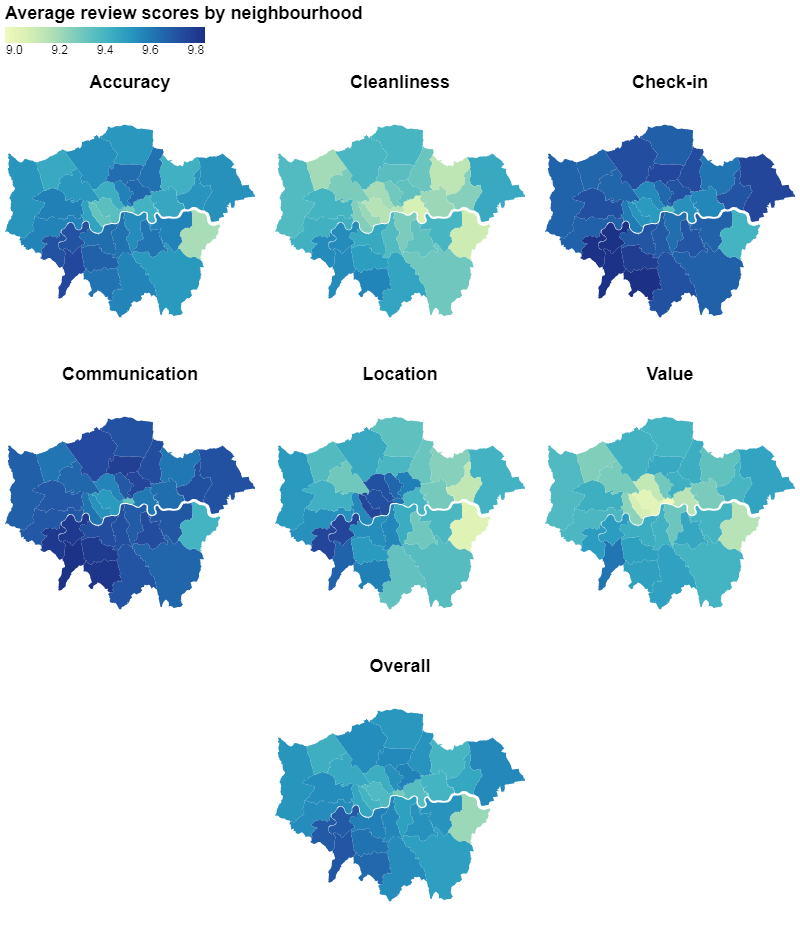

In [59]:
review_cols = ['mean_review_scores_accuracy', 'mean_review_scores_cleanliness', 'mean_review_scores_checkin',
               'mean_review_scores_communication', 'mean_review_scores_location', 'mean_review_scores_value']
review_titles = ['Accuracy', 'Cleanliness', 'Check-in',
                 'Communication', 'Location', 'Value']
review_map = {col: title for col, title in zip(review_cols, review_titles)}

result_df = geo_listings_df[['geometry', 'neighbourhood', 'mean_review_scores_all'] + review_cols].drop_duplicates()

def gen_map_chart(df, review_col, review_title):
    '''Generate choropleth map
    
    Generate choropleth map based on scores of specific review types
    
    :param df: DataFrame with necessary geo data and review scores for different neighbourhood
    :type df: DataFrame
    :param review_col: name of review scores type
    :type review_col: str
    :param review_title: title of review scores type
    :type review_title: str
    :return: Altair Chart for displaying 
    :rtype: Chart
    '''
    chart = alt.Chart(
        df,
        title=review_title
    ).mark_geoshape().encode(
        color=f'{review_col}:Q',
        tooltip=['neighbourhood:N', f'{review_col}:Q']
    ).properties(
        width=250, 
        height=250
    )
    
    return chart

charts = []

for review_col, review_title in zip(review_cols, review_titles):
    charts.append(gen_map_chart(result_df, review_col, review_title))

overall_map_chart = gen_map_chart(result_df, 'mean_review_scores_all', 'Overall')

((alt.vconcat(alt.concat(*charts, columns=3), overall_map_chart, 
              title='Average review scores by neighbourhood', 
              center=True)
     .configure_view(strokeWidth=0)
     .configure_title(fontSize=18)
     .configure_legend(title=None, orient='top',  labelFontSize=12)))

**Conclusions**
- Neighbourhoods in the center of London are more attractive by location for guests, especially on the north side of the Thames (average review score by location):
    - Kensington and Chelsea (~9.76)
    - Westminster (~9.73)
    - Camden (~9.73)
- Center regions are not so good for guests in other aspects.   
  It seems like central regions either are too expensive or hosts in the center don't pay such attention to different aspects like other hosts
- There is probably a bias between different types of reviews, so several review types have much more average score (e.g. Check-in and Communication) than the other ones (e.g. Cleanliness)
- The best regions in general (corresponding to overall mean guest review scores) are located on the Southwest of London (overall average review score):
    - Kingston Upon Thames (~9.70)
    - Richmond Upon Thames (~9.69)
- There is the region which is worst for most of the review types and in general (overall average review score):
    - Bexley (~9.2)

### Are there any relationships between different types of guest review scores? <a class="anchor" id="question-2"></a>
- Different review types can be related with the other ones while another reviews can be independent
- This information can be used for score prediction based on known values of another guest review types

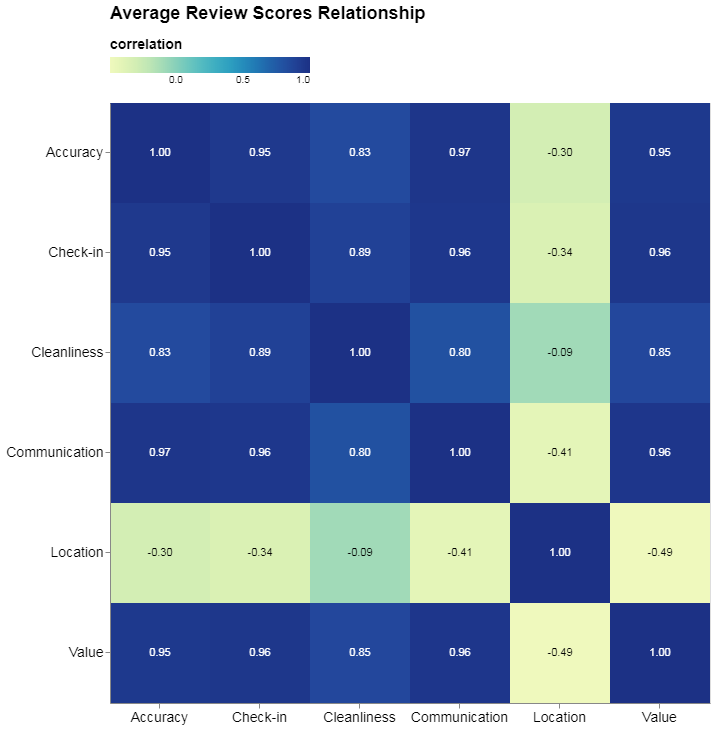

In [61]:
result_df = (geo_listings_df[review_cols].rename(review_map, axis=1)
                                         .corr()
                                         .reset_index()
                                         .melt(id_vars='index')
                                         .rename({'value': 'correlation'}, axis=1))

base = alt.Chart(
    result_df,
    title='Average Review Scores Relationship'
).properties(
    width=600, 
    height=600
)

heatmap = base.mark_rect().encode(
    x=alt.X('index:N', title=None),
    y=alt.Y('variable:N', title=None),
    color='correlation:Q'
)

text = base.mark_text(baseline='middle').encode(
    x=alt.X('index:N', title=None),
    y=alt.Y('variable:N', title=None),
    text=alt.Text('correlation:Q', format='.2f'),
    color=alt.condition(
        alt.datum.correlation < 0,
        alt.value('black'),
        alt.value('white')
    )
)

(heatmap + text).configure_axis(
    labelAngle=0,
    labelFontSize=14
).configure_legend(
    orient='top',
    titleFontSize=14,    
).configure_title(
    fontSize=18,
    offset=15,
    anchor='start',
    frame='group'
)

**Conclusions**
- There is a strong positive relationship between review scores except for Location review scores
    - If the guests give high scores for Accuracy, Check-in, Cleanliness, Communication or Value, it is much likely that other 4 review scores will be also high
- There is a negative relationship between location review scores and the other ones
    - If the guest give high score to location of the listing, it is much likely that other aspects of the listing will not be such attractive
- It seems like cleanliness review scores are most independent from other reviews scores

### How host/listings properties are related with guest review scores? <a class="anchor" id="question-3"></a>
- Different aspects of listings and its owners (hosts) can have influence on guest review scores
- This information can be used to determine possible host and listing features that can be improved

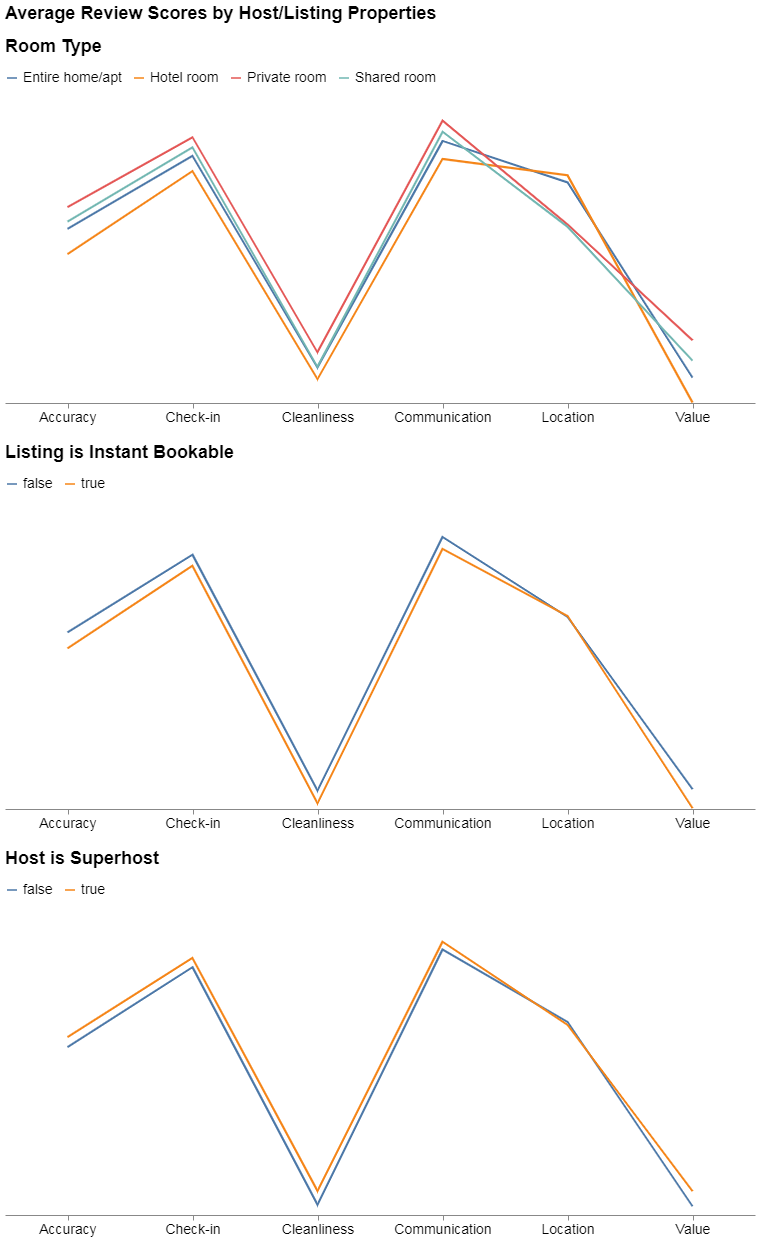

In [63]:
def gen_parallel_chart(df, class_col, class_title):
    '''Generate parallel coordinates chart
    
    Generate parallel coordinates chart based on specific class column by different review score types
    
    :param df: DataFrame with necessary data for class column calculation
    :type df: DataFrame
    :param class_col: name of class column 
    :type class_col: str
    :param class_title: title of review scores type
    :type class_title: str
    :return: Altair Chart for displaying 
    :rtype: Chart
    '''
    result_df = (df.groupby(class_col)[review_cols]
                   .mean()
                   .reset_index()
                   .melt(id_vars=class_col))
    result_df['variable'] = result_df['variable'].map(review_map)

    chart = alt.Chart(
        result_df,
        title = f'{class_title}'
    ).mark_line().encode(
        x=alt.X('variable:N',
                title=None),
        y=alt.Y('value:Q',
                scale=alt.Scale(zero=False),
                axis=None),
        color=f'{class_col}:N'
    ).properties(
        width=750, 
        height=300
    )
    
    return chart

class_cols = ['room_type', 'instant_bookable', 'host_is_superhost']
class_titles = ['Room Type', 'Listing is Instant Bookable', 'Host is Superhost']

charts = []

for class_col, class_title in zip(class_cols, class_titles):
    charts.append(gen_parallel_chart(geo_listings_df, class_col, class_title))
    
(alt.concat(*charts, columns=1, title='Average Review Scores by Host/Listing Properties')
    .configure_view(strokeWidth=0)
    .configure_legend(
        title=None, 
        orient='top', 
        columns=0,
        labelFontSize=14)
    .configure_axis(
        labelAngle=0,
        grid=False,
        labelFontSize=14)
    .configure_title(
        anchor='start',
        fontSize=18,
        offset=15)
    .resolve_scale(color='independent')
)

**Conclusions**
- Guest reviews for private and shared rooms are consistently greater than for other room types (except for Location)
- For Location review scores, the best room types are entire home/apartments and hotel rooms
- If additional approval from host is not required for booking (instant bookable listings), then guest reviews are consistently better (except for Location)
- If host has the status of Superhost, then guest reviews are consistently better (except for Location)

## Evaluation <a class="anchor" id="evaluation"></a>

### Evaluate results <a class="anchor" id="evaluate-results"></a>

**Assessment of data mining results with respect to business success criteria**
- Different review scores have strong relationship between themselves and with different host/listing/neighbourhood properties
- These relationships can be used for further analysis how to improve hosts reputation and Airbnb reputation in general

### Review process <a class="anchor" id="review-process"></a>

**Review of process**

- Data collected from Airbnb site was used to explore relationship of guest reviews with different aspects of hosts and listings
- Only subset of Airbnb listings with all non-empty review score types were selected for analysis
- Only small subset of features was selected for analyis based on assumptions which features can have most strong relationship with guest review scores
- There was no filtering of listings based on availability/price
- Only descriptive statistics were used for analysis

### Determine next steps <a class="anchor" id="next-steps"></a>

**List of possible actions**
- Find possible usage of already found relationship to motivate hosts to improve guest experience
- Continue data understanding
    - Use another features from listings dataset
        - Different host/listing properties
    - Use another files from dataset for further exploration and analysis
        - Reviews
            - Review texts
        - Calendar data
            - Availabitily
            - Price